### Load the datasets

In [1]:
import pandas as pd
X_train = pd.read_csv('X_train_grouped.csv')
X_val = pd.read_csv('X_val_grouped.csv')
X_test = pd.read_csv('X_test_grouped.csv')
y_train = pd.read_csv('y_train_grouped.csv')
y_val = pd.read_csv('y_val_grouped.csv')
y_test = pd.read_csv('y_test_grouped.csv')

In [9]:
X_train = X_train.drop(columns=["matchId"])
X_val = X_val.drop(columns=["matchId"])
X_test = X_test.drop(columns=["matchId"])


### Define a model_builder function to allow the tuner to dynamically build the model

In [16]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(X_train.shape[1],)))
    for i in range(hp.Int("num_layers", 2, 8)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=256, step=32),
                activation="relu"
            )
        )
    model.add(keras.layers.Dropout(hp.Float("dropout", 0, 0.5, step=0.1)))
    model.add(keras.layers.Dense(units=1, activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])
        ),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    
    return model

In [10]:
X_train.dtypes

assists                       float64
boosts                        float64
damageDealt                   float64
DBNOs                         float64
headshotKills                 float64
heals                         float64
kills                         float64
revives                       float64
rideDistance                  float64
roadKills                     float64
swimDistance                  float64
teamKills                     float64
vehicleDestroys               float64
walkDistance                  float64
weaponsAcquired               float64
killPlace                     float64
killPoints                    float64
killStreaks                   float64
longestKill                   float64
rankPoints                    float64
winPoints                     float64
matchDuration                 float64
maxPlace                      float64
numGroups                     float64
matchType_crashfpp              int64
matchType_crashtpp              int64
matchType_du

### Run the model training using HyperBand for HyperParameter tuning

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_mean_absolute_error',
    patience=15,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True
)

hb_tuner = kt.Hyperband(
    model_builder,
    objective = "val_mean_absolute_error",
    max_epochs = 50,
    factor = 4,
    directory = "hb_grouped_tuning",
    project_name = "hb_grouped_tuning"
)

hb_tuner.search(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    batch_size=2048
)

best_hps = hb_tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
best_model = hb_tuner.hypermodel.build(best_hps)
best_model.save("hb_best_model_grouped.h5")

c:\Users\marco\Desktop\Uni\Magistrale\AML\Progetto\ProgettoAML\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Trial 44 Complete [00h 02m 37s]
val_mean_absolute_error: 0.04830806329846382

Best val_mean_absolute_error So Far: 0.04830806329846382
Total elapsed time: 00h 34m 02s
{'num_layers': 7, 'units_0': 216, 'units_1': 176, 'dropout': 0.1, 'learning_rate': 0.001, 'units_2': 40, 'units_3': 224, 'units_4': 256, 'units_5': 144, 'units_6': 64, 'units_7': 32, 'tuner/epochs': 50, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


### Run the model training using BayesianSearch for HyperParameter tuning

In [19]:
early_stopping = EarlyStopping(
    monitor='val_mean_absolute_error',
    patience=15,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True
)

bayes_tuner = kt.BayesianOptimization(
    model_builder,
    objective = "val_mean_absolute_error",
    max_trials = 50,
    num_initial_points = 5,
    directory = "bayes_grouped_tuning",
    project_name = "bayes_grouped_tuning"

)

bayes_tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping],    batch_size = 2048)

best_hps = bayes_tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
best_model = bayes_tuner.hypermodel.build(best_hps)
best_model.save("bayes_best_model_grouped.h5")

c:\Users\marco\Desktop\Uni\Magistrale\AML\Progetto\ProgettoAML\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Trial 50 Complete [00h 01m 52s]
val_mean_absolute_error: 0.04861258342862129

Best val_mean_absolute_error So Far: 0.04808535799384117
Total elapsed time: 01h 32m 39s
{'num_layers': 4, 'units_0': 256, 'units_1': 224, 'dropout': 0.2, 'learning_rate': 0.001, 'units_2': 32, 'units_3': 32}


In [ ]:
best_model = bayes_tuner.hypermodel.build(best_hps,
    early_stopping = EarlyStopping(
    monitor='val_mean_absolute_error',
    patience=15,
    min_delta=0.0001,
    mode='min',
    restore_best_weights=True
) )
history = best_model.fit(X_train, y_train, epochs=150, validation_data=(X_val, y_val), batch_size=2048)

c:\Users\marco\Desktop\Uni\Magistrale\AML\Progetto\ProgettoAML\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/150
634/634 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0129 - mean_absolute_error: 0.0814 - val_loss: 0.0053 - val_mean_absolute_error: 0.0536
Epoch 2/150
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0060 - mean_absolute_error: 0.0578 - val_loss: 0.0051 - val_mean_absolute_error: 0.0523
Epoch 3/150
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0057 - mean_absolute_error: 0.0561 - val_loss: 0.0049 - val_mean_absolute_error: 0.0513
Epoch 4/150
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0055 - mean_absolute_error: 0.0553 - val_loss: 0.0048 - val_mean_absolute_error: 0.0504
Epoch 5/150
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0054 - mean_absolute_error: 0.0550 - val_loss: 0.0048 - val_mean_absolute_error: 0.0509
Epoch 6/150
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0054 - mean_absolute_error: 0.0546 - val_loss: 0.0047 - val_mean_absolute_error: 0.0499
Epoch 7/150
634/634 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0053 - mean_absolute_error: 0.0

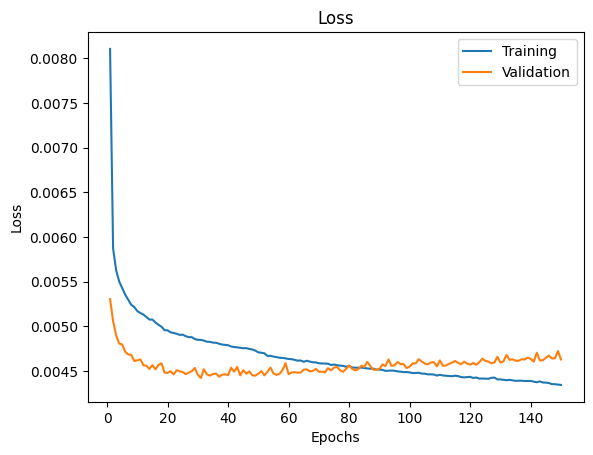

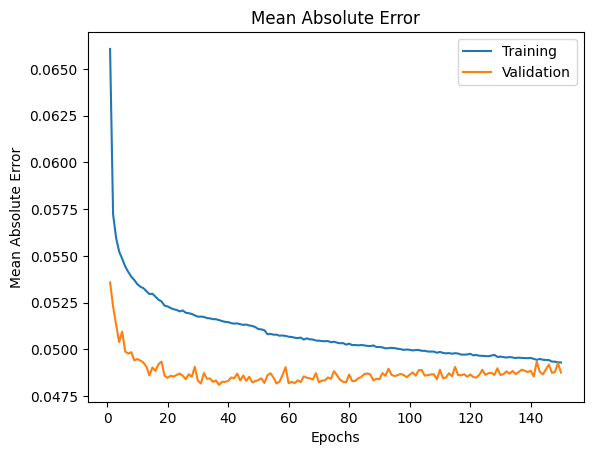

In [24]:
from matplotlib import pyplot as plt

def plot_loss(history):
  x_plot = list(range(1,len(history.history["loss"])+1))
  plt.figure()
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])
  
def plot_mae(history):
    x_plot = list(range(1,len(history.history["mean_absolute_error"])+1))
    plt.figure()
    plt.title("Mean Absolute Error")
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.plot(x_plot, history.history['mean_absolute_error'])
    plt.plot(x_plot, history.history['val_mean_absolute_error'])
    plt.legend(['Training', 'Validation'])
    
plot_loss(history)
plot_mae(history)


In [26]:
best_model.save("bayes_best_model_grouped_trained.keras")